In [1]:
import re
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

# Reading the Data

In [2]:
product_ids = []
product_title = []
product_group = []
product_salesrank = []
product_reviews = []
product_downloaded = []
product_rating = []

review_product = []
review_date = []
review_customer = []
review_rating = []
review_vote = []
review_helpful = []

num_categories = 0
categories = defaultdict(list)
subcategories = defaultdict(list)
cat_flag = False

with gzip.open('amazon-meta.txt.gz', 'rt') as infile:
    for line in infile:
        if line.startswith('ASIN:'):
            temp, product = line.split()
        elif line.strip().startswith('title:'):
            temp, title = line.split(':', maxsplit=1)
            title = title.strip()
            product_ids.append(product)
            product_title.append(title)
        elif line.strip().startswith('group:'):
            temp, group = line.split(':')
            group = group.strip()
            product_group.append(group)
        elif line.strip().startswith('salesrank:'):
            temp, salesrank = line.split()
            product_salesrank.append(int(salesrank))
        elif line.strip().startswith('categories:'):
            info = line.split()
            num_categories += int(info[1])
            cat_flag = True
        elif cat_flag and not line.strip().startswith('reviews:'):
            categories[group] += [line.strip()]
            temp = [s.strip() for s in line.split('|')]
            subcategories[group] += [s for s in temp if len(s) > 0]
        elif line.strip().startswith('reviews:'):
            cat_flag = False
            review_info = line.split()
            product_reviews.append(int(review_info[2]))
            product_downloaded.append(int(review_info[4]))
            product_rating.append(float(review_info[-1]))
        elif 'cutomer' in line:
            review_info = line.split()
            review_product.append(product)
            review_date.append(review_info[0])
            review_customer.append(review_info[2])
            review_rating.append(int(review_info[4]))
            review_vote.append(int(review_info[6]))
            review_helpful.append(int(review_info[8]))

products = pd.DataFrame({'product_id': product_ids, 'title': product_title, 'group': product_group,
                         'salesrank': product_salesrank, 'reviews': product_reviews,
                         'downloaded_reviews': product_downloaded, 'rating': product_rating})
reviews = pd.DataFrame({'product_id': review_product, 'date': review_date, 'customer_id': review_customer, 
                       'rating': review_rating, 'votes': review_vote, 'helpful': review_helpful})

In [3]:
products.head()

,downloaded_reviews,group,product_id,rating,reviews,salesrank,title
0,2,Book,0827229534,5.0,2,396585,Patterns of Preaching: A Sermon Sampler
1,12,Book,0738700797,4.5,12,168596,Candlemas: Feast of Flames
2,1,Book,0486287785,5.0,1,1270652,World War II Allied Fighter Planes Trading Cards
3,1,Book,0842328327,4.0,1,631289,Life Application Bible Commentary: 1 and 2 Tim...
4,0,Book,1577943082,0.0,0,455160,Prayers That Avail Much for Business: Executive


In [4]:
reviews.head()

,customer_id,date,helpful,product_id,rating,votes
0,A2JW67OY8U6HHK,2000-7-28,9,0827229534,5,10
1,A2VE83MZF98ITY,2003-12-14,5,0827229534,5,6
2,A11NCO6YTE4BTJ,2001-12-16,4,0738700797,5,5
3,A9CQ3PLRNIR83,2002-1-7,5,0738700797,4,5
4,A13SG9ACZ9O5IM,2002-1-24,8,0738700797,5,8


# Investigating Ratings
A simple bar chart shows that the ratings distribution is highly skewed and the vast majority of ratings are either a 4 or a 5. This could indicate ratings manipulation where people flood Amazon with positive reviews, or could simply indicate that people who like products are more likely to review them.

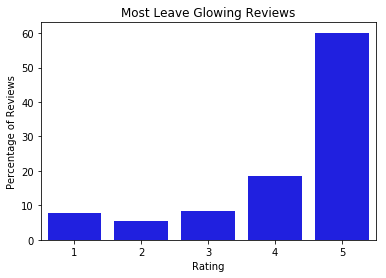

In [5]:
counts = reviews.groupby('rating').votes.count()
sns.barplot(counts.index, 100 * counts / len(reviews), color='blue')
plt.xlabel('Rating')
plt.ylabel('Percentage of Reviews')
plt.title('Most Leave Glowing Reviews')
plt.show()

The percentages below futher illustrate the skewness in the ratings where 60% of all reviews are 5 stars and nearly 80% are a 4 or 5.

In [6]:
print('The average review in the dataset is {:.2f}'.format(reviews.rating.mean()))
print('5-star reviews make up {:.2f}% of all reviews'.format(100 * sum(reviews.rating==5) / len(reviews)))
print('4 and 5-star reviews make up {:.2f}% of all reviews'.format(100 * sum(reviews.rating>3) / len(reviews)))

The average review in the dataset is 4.18
5-star reviews make up 60.11% of all reviews
4 and 5-star reviews make up 78.57% of all reviews


# Categories
There are over 2.5 million different category entries applied to products in the dataset. This is the sum of the number of categories applied to all products, not the size of the set of unique categories.

In [7]:
print(num_categories)

2509699


The categories variable contains a dictionary of lists where the keys are the different product groups and the values are lists of each products' category entries. The line below simply sums up the length of all the lists as a check that the data was read properly. The sum below matches the count above, which provides some confidence in the data parsing.

In [8]:
print(sum([len(x) for x in categories.values()]))

2509699


If we only look at book categories, we see over half of all category entries in the dataset are book categories.

In [9]:
print(len(categories['Book']))

1440329


In [10]:
categories['Book'][:10]

['|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486]',
 '|Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Reference[172810]|Commentaries[12155]|New Testament[12159]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Discipleship[12335]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Translations[764432]|Life Application[572080]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Bible

After creating a set of the book category entries, we find there are almost 13,000 unique book categories.

In [11]:
cat_set = set(categories['Book'])
print(len(cat_set))

12853


The line below creates a counter of the book categories, which is a special dictionary whose values contain the number of occurances in the collection used to create the counter.

In [12]:
cat_counts = Counter(categories['Book'])

To identify redundancy in the categorization, I first looked at categories that contained a couple keywords and appeared on more than 100 products. If we look at categories that contain the word fantasy, we see there are different entries for "Science Fiction & Fantasy" depending on if it is a teen novel, a book on tape, or general science fiction and fanctasy.

In [13]:
[k for (k, v) in cat_counts.items() if 'Fantasy' in k and v > 100]

['|Books[283155]|Subjects[1000]|Science Fiction & Fantasy[25]|Fantasy[16190]|History & Criticism[16203]',
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Comics & Graphic Novels[3014]",
 '|Books[283155]|Subjects[1000]|Teens[28]|Science Fiction & Fantasy[17466]|Fantasy[17468]',
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Science Fiction, Fantasy, & Magic[3017]",
 '|Books[283155]|Subjects[1000]|Teens[28]|Science Fiction & Fantasy[17466]|Science Fiction[17470]',
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Spine-Chilling Horror[3018]",
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Mysteries, Espionage, & Detectives[3016]",
 '|Books[283155]|Subjects[1000]|Science Fiction & Fantasy[25]|Fantasy[16190]|Genera

Looking at "Mystery & Thrillers" we see something similar for books, books on tape, and books on CD.

In [14]:
[k for (k, v) in cat_counts.items() if 'Mystery' in k and v > 100]

["|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Comics & Graphic Novels[3014]",
 '|Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|Mystery[10457]|General[10466]',
 '|Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|General[605116]',
 '|Books[283155]|Formats[504358]|Books on Tape[44]|Mystery & Thrillers[2303]|Mystery[2304]',
 '|Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|Mystery[10457]|British Detectives[10461]',
 '|Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|Mystery[10457]|Sherlock Holmes[10477]',
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Science Fiction, Fantasy, & Magic[3017]",
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantasy, Mystery & Horror[3013]|Spine-Chilling Horror[3018]",
 "|Books[283155]|Subjects[1000]|Children's Books[4]|Literature[2966]|Science Fiction, Fantas

Looking at the most common categories we see the top two are very similar.

In [15]:
list(cat_counts.most_common())[:10]

[('|[265523]|Amazon.com Stores[285080]|Home & Office[764512]|Business & Investing Books[767740]|General[767880]',
  18438),
 ('|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612]',
  18436),
 ('|Books[283155]|Subjects[1000]|Reference[21]|General[408268]', 13701),
 ('|Books[283155]|Subjects[1000]|Biographies & Memoirs[2]|General[2375]',
  12241),
 ('|Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|General[11289]',
  11779),
 ('|Books[283155]|Subjects[1000]|Literature & Fiction[17]|General[10125]|Contemporary[10129]',
  11446),
 ("|Books[283155]|Subjects[1000]|Children's Books[4]|Ages 4-8[2785]|General[170062]",
  11439),
 ('|Books[283155]|Subjects[1000]|Nonfiction[53]|Education[10605]|General[10635]',
  8759),
 ('|Books[283155]|Subjects[1000]|Computers & Internet[5]|General[657762]',
  8660),
 ('|Books[283155]|Subjects[1000]|Health, Mind & Body[10]|Psychology & Counseling[11119]|General[11175]',
  8064)]

Looking at the least common categories we see a number of categories for authors that only appear once, which do not seem necessary. These also seem to be related to DVDs, which is confusing why they appear as book categories.

In [16]:
list(reversed(cat_counts.most_common()))[:10]

[('|[139452]|DVD[130]|Genres[404276]|Comedy[163357]|By Theme[291103]|Unlikely Heroes[14155061]',
  1),
 ('|[139452]|DVD[130]|Genres[404276]|Comedy[163357]|Comedy Stars[899692]|Robin Williams[899760]',
  1),
 ('|[265523]|Amazon.com Stores[285080]|Amazon.com Outlet[517808]|Categories[526028]|DVD Outlet[734006]|Deals Under $20[734044]',
  1),
 ('|[139452]|DVD[130]|Special Features[408328]|Titles[579510]|( F )[579522]',
  1),
 ("|[139452]|DVD[130]|Special Features[408328]|Today's Deals in DVD[409298]|Deals Under $20[565162]",
  1),
 ('|[139452]|DVD[130]|Directors[403502]|( M )[459370]|Mayfield, Les[459706]',
  1),
 ('|[139452]|DVD[130]|Actors & Actresses[404278]|( Z )[453752]', 1),
 ('|[139452]|DVD[130]|Actors & Actresses[404278]|( W )[451116]|Williams, Robin[452712]',
  1),
 ('|[139452]|DVD[130]|Actors & Actresses[404278]|( W )[451116]|Wheaton, Wil[452218]',
  1),
 ('|[139452]|DVD[130]|Actors & Actresses[404278]|( S )[444858]|Stefanson, Leslie[447884]',
  1)]

If we naively remove all categories that appear less than 100 times, we are left with about 20% of the categories while keeping 85% of the category entries.

In [17]:
threshold = 100
temp = [v for v in cat_counts.values() if v > threshold]
print('Number of remaining categories: {}'.format(len(temp)))
print('Percentage of remaining categories: {:.2f}%'.format(100 * len(temp) / len(cat_set)))
print('Number of remaining entries: {}'.format(sum(temp)))
print('Percentage of remaining entries: {:.2f}%'.format(100 * sum(temp) / len(categories['Book'])))

Number of remaining categories: 2511
Percentage of remaining categories: 19.54%
Number of remaining entries: 1225068
Percentage of remaining entries: 85.05%


To further investigate category redundancy, I split all category entries on the separator. The subcategories variable contains all the subcategories regardless of their position in the product category hierarchy.

In [18]:
subcategories['Book'][:10]

['Books[283155]',
 'Subjects[1000]',
 'Religion & Spirituality[22]',
 'Christianity[12290]',
 'Clergy[12360]',
 'Preaching[12368]',
 'Books[283155]',
 'Subjects[1000]',
 'Religion & Spirituality[22]',
 'Christianity[12290]']

The number of category entries in this view jumps up to 7.9 million.

In [19]:
print(len(subcategories['Book']))

7891047


There are almost 15,000 unique categories in this view. This is higher than the previous count, but that is expected since each category was split into multiple subcategories.

In [20]:
cat_set = set(subcategories['Book'])
print(len(cat_set))

14923


Looking at subcategories that contain the keyword fantasy, we see that "Science Fiction & Fantasy" appears multiple times with different IDs.

In [21]:
[c for c in cat_set if 'Fantasy' in c]

['Dark Fantasy[9803]',
 'Fantasy[1038366]',
 'Science Fiction & Fantasy[12038]',
 'Science Fiction & Fantasy[1038330]',
 'Science Fiction & Fantasy[68145]',
 'Science Fiction & Fantasy[11754]',
 'Science Fiction & Fantasy[13622611]',
 'Fantasy[1038332]',
 'Fantasy[586098]',
 'Fantasy[265561]',
 'Final Fantasy[768684]',
 'Fantasy[3825111]',
 'Role Playing & Fantasy[4442]',
 'Fantasy & Adventure[3328]',
 'Science Fiction & Fantasy[733908]',
 'Final Fantasy[696960]',
 'Science Fiction & Fantasy[2324]',
 'Final Fantasy[3434]',
 'Fantasy, Futuristic & Ghost[13356]',
 'Fantasy[17468]',
 'Science Fiction, Fantasy, & Magic[3017]',
 'Fantasy[16190]',
 'Science Fiction & Fantasy[25]',
 'Science Fiction & Fantasy[17466]',
 'Science Fiction & Fantasy[2504]',
 'Fantasy[13436171]',
 'Science Fiction & Fantasy[300959]',
 'Science Fiction, Fantasy, Mystery & Horror[3013]']

The same goes for "Mystery & Thrillers."

In [22]:
[c for c in cat_set if 'Mystery' in c]

['Mystery & Detective[3360]',
 'Mystery[2304]',
 'Mystery & Thrillers[13622521]',
 'Mystery[4393]',
 'Mystery[13436191]',
 'Mystery & Thrillers[2303]',
 'Mystery & Thrillers[1038316]',
 'Sports Mystery[281877]',
 'Mystery[12034]',
 'Babysitters Club Mystery[281811]',
 'Mystery & Thrillers[300958]',
 'Sebastian Barth Mystery[290730]',
 'Mystery[400106]',
 'Scooby-Doo Mystery[281836]',
 'Mystery & Thrillers[301806]',
 'Mystery & Thrillers[18]',
 'Mystery[12498]',
 'Mystery[10457]',
 'Science Fiction, Fantasy, Mystery & Horror[3013]']

The presence of the category ID results in many duplicates. If we create a set of all subcategories with the ID removed, we see the number of unique subcategories is reduced by more than 40%. 

In [23]:
cat_noid = [re.sub('\[\d+\]', '', x) for x in subcategories['Book']]
cat_set_noid = set(cat_noid)
print(len(cat_set_noid))
print('{:.2f}%'.format(100 * len(cat_set_noid) / len(cat_set)))

8578
57.48%


Looking at the least common subcategories we again see a number of authors only appear once.

In [24]:
cat_counts = Counter(cat_noid)
list(reversed(cat_counts.most_common()))[:10]

[('Unlikely Heroes', 1),
 ('Robin Williams', 1),
 ('Comedy Stars', 1),
 ('Titles', 1),
 ('Mayfield, Les', 1),
 ('Wheaton, Wil', 1),
 ('Stefanson, Leslie', 1),
 ('McDonald, Christopher', 1),
 ('McClurg, Edie', 1),
 ('Matthews, Dakin', 1)]

If we remove all subcategories that appear less than 100 times, we are left with less than 15% of the original subcategories, but over 98% of the entries. There are a significant number of subcategories that are not used very often and potentially do not add much value.

In [25]:
threshold = 100
temp = [v for v in cat_counts.values() if v > threshold]
print('Number of remaining subcategories: {}'.format(len(temp)))
print('Percentage of remaining subcategories: {:.2f}%'.format(100 * len(temp) / len(cat_set)))
print('Number of remaining entries: {}'.format(sum(temp)))
print('Percentage of remaining entries: {:.2f}%'.format(100 * sum(temp) / len(subcategories['Book'])))

Number of remaining subcategories: 2159
Percentage of remaining subcategories: 14.47%
Number of remaining entries: 7761954
Percentage of remaining entries: 98.36%


The plot below shows the percentage of remaining subcategories and entries for a range of threshold values. The distribution decays quickly where even a threshold of only 20 reduces the number of subcategories by about 70% with little impact on the number of entries.

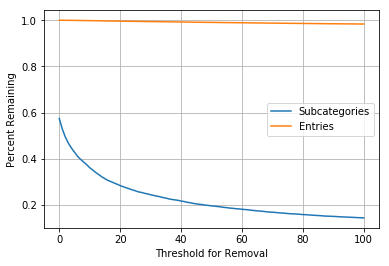

In [26]:
subcat = []
entries = []
limit = 100

for threshold in range(limit+1):
    temp = [v for v in cat_counts.values() if v > threshold]
    subcat += [len(temp) / len(cat_set)]
    entries += [sum(temp) / len(subcategories['Book'])]

plt.plot(range(limit+1), subcat)
plt.plot(range(limit+1), entries)
plt.grid()
plt.xlabel('Threshold for Removal')
plt.ylabel('Percent Remaining')
plt.legend(['Subcategories', 'Entries'])
plt.show()

# Algorithm Thinking
If I were to build the product categorization from scratch, I would use a clustering technique that used product information and information on co-purchased products to group products. Once the products are grouped, I would look at the most common existing categories for the products in each group and apply them to all products in each group. If the goal is to not use the existing product categories at all, then I would apply categories to a select few popular products across a range of perceived categories and apply the categories to all products in the groups.

## Product Thinking
I absolutely feel that users should be able to see categories for products. That being said, I'm not sure that seeing the category hierarchy is all that important, which might bog down users and provide too much information. Showing customers similar/co-purchased products is a good idea because it can introduce users to products they are not familiar with and potentially increase sales. I have certainly purchased items on Amazon I learned about after seeing them as similar products to items I was already interested in. It is also a good idea to show customers ratings and reviews because it helps give a sense of product quality. While ratings are subject to manipulation and bias, they can still be a helpful tool provided users are cognizant of their issues and read reviews in addition to looking at ratings.